In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
from sklearn.feature_selection import RFE
import matplotlib.ticker as mtick # For specifying the axes tick format 

In [3]:
# Load the dataset
df = pd.read_csv('Telco_Churn_Customer.csv')

In [4]:
df.columns.values

array(['CUSTOMER_ID', 'SERVICE_ID', 'GENDER', 'AGE', 'SENIORCITIZEN',
       'PARTNER', 'DEPENDENTS', 'CITY', 'STATE', 'COUNTRY', 'ZIP_CODE',
       'CUSTOMER_SINCE', 'CUSTOMER_SEGMENT', 'CUSTOMER_TYPE',
       'CUSTOMER_DISCONNCT_DATE', 'CUSTOMER_STATUS', 'TENURE',
       'PHONE_SERVICE', 'MULTIPLE_LINES', 'INTERNET_SERVICE',
       'DATA_USAGE', 'TEXT_MSGS', 'VOICE_MINUTES', 'MONTHLY_BILL',
       'CHURN_REASON', 'CHURNED', 'Contract', 'PaymentMethod',
       'PaperlessBilling'], dtype=object)

In [5]:
df.describe()

,CUSTOMER_ID,AGE,SENIORCITIZEN,ZIP_CODE,TENURE,DATA_USAGE,TEXT_MSGS,VOICE_MINUTES,MONTHLY_BILL
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,4.975517e+07,53.310600,0.344650,110021.880950,68.461400,4.587247,276.64720,226.105450,354.130566
std,2.882414e+07,20.734498,0.475266,29.551706,53.917799,3.104690,330.11182,266.281787,105.228376
min,2.063000e+03,18.000000,0.000000,110001.000000,0.000000,0.000000,0.00000,0.000000,205.500000
25%,2.482444e+07,35.000000,0.000000,110002.000000,18.000000,1.850000,0.00000,0.000000,267.752500
50%,4.964155e+07,53.000000,0.000000,110006.000000,59.000000,4.590000,106.50000,104.000000,320.810000
75%,7.469197e+07,71.000000,1.000000,110024.000000,116.000000,7.320000,553.00000,456.000000,440.420000
max,9.999762e+07,89.000000,1.000000,110085.000000,173.000000,10.000000,999.00000,799.000000,659.320000


C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_4540\4226148616.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CUSTOMER_SINCE'] = pd.to_datetime(df['CUSTOMER_SINCE'])


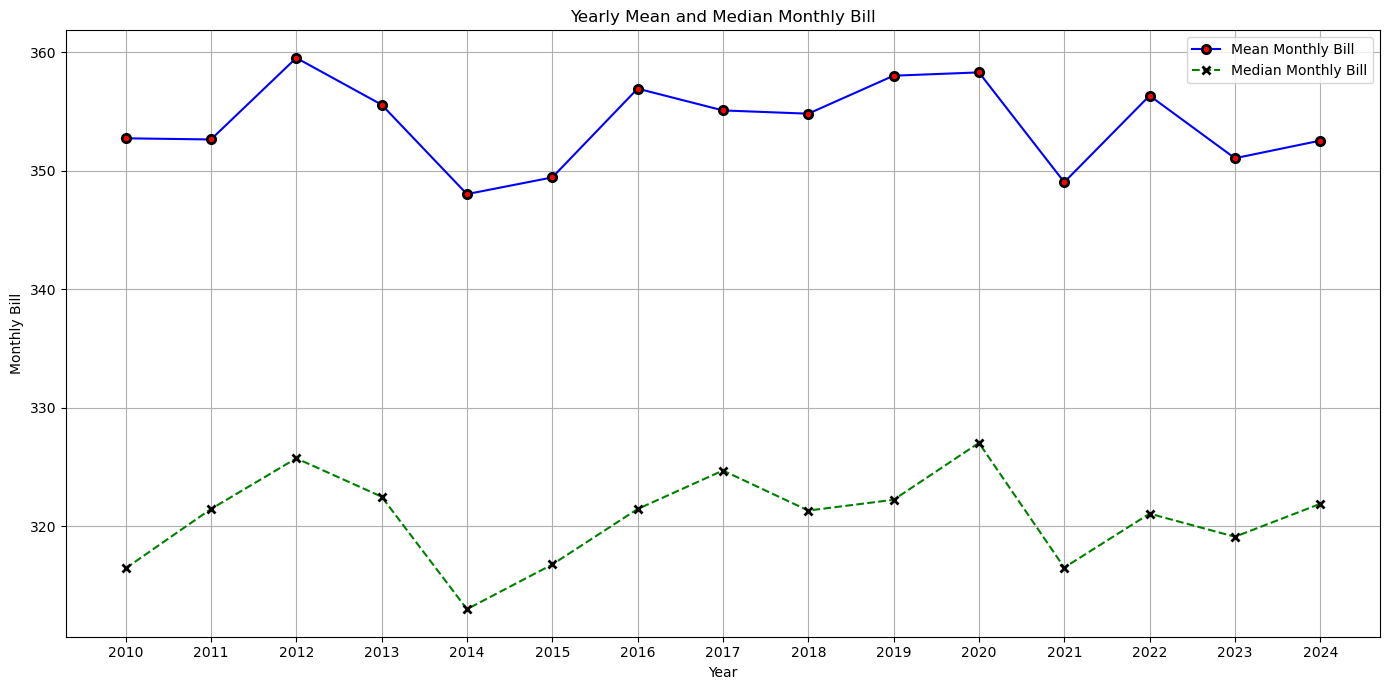

In [6]:


if 'CUSTOMER_SINCE' in df.columns:
    df['CUSTOMER_SINCE'] = pd.to_datetime(df['CUSTOMER_SINCE'])


df['Year'] = df['CUSTOMER_SINCE'].dt.year


yearly_bill_stats = df.groupby('Year')['MONTHLY_BILL'].agg(['mean', 'median'])


yearly_bill_stats.columns = ['Mean Monthly Bill', 'Median Monthly Bill']

# Plotting
plt.figure(figsize=(14, 7))


plt.plot(yearly_bill_stats.index, yearly_bill_stats['Mean Monthly Bill'], 
         label='Mean Monthly Bill', 
         color='blue',          # Line color
         linestyle='-',       # Line style
         marker='o',          # Marker style
         markerfacecolor='red', # Color of the dots
         markeredgewidth=2,   # Width of the edge around the marker
         markeredgecolor='black') # Color of the edge around the marker


plt.plot(yearly_bill_stats.index, yearly_bill_stats['Median Monthly Bill'], 
         label='Median Monthly Bill', 
         color='green',        # Line color
         linestyle='--',       # Line style
         marker='x',           # Marker style
         markerfacecolor='yellow', # Color of the dots
         markeredgewidth=2,    # Width of the edge around the marker
         markeredgecolor='black') # Color of the edge around the marker

plt.title('Yearly Mean and Median Monthly Bill')
plt.xlabel('Year')
plt.ylabel('Monthly Bill')
plt.xticks(yearly_bill_stats.index)  # Set x-ticks to be the years
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig('yearly_mean_median_monthly_bill.png', format='png', dpi=300)

# Optionally, show the plot
plt.show()


## 1. Demographic and Usage Patterns

## 1) Age Distribution Histogram: How does the age distribution of churned customers compare to retained customers?

In [8]:

df = df.drop(columns=['CUSTOMER_ID', 'SERVICE_ID','STATE', 'COUNTRY', 'ZIP_CODE','CUSTOMER_SINCE','CUSTOMER_DISCONNCT_DATE'])


In [9]:

df['DATA_USAGE'] = pd.to_numeric(df['DATA_USAGE'], errors='coerce')
df['MONTHLY_BILL'] = pd.to_numeric(df['MONTHLY_BILL'], errors='coerce')


print("Missing values after conversion:")
print(df.isnull().sum())

Missing values after conversion:
GENDER              0
AGE                 0
SENIORCITIZEN       0
PARTNER             0
DEPENDENTS          0
CITY                0
CUSTOMER_SEGMENT    0
CUSTOMER_TYPE       0
CUSTOMER_STATUS     0
TENURE              0
PHONE_SERVICE       0
MULTIPLE_LINES      0
INTERNET_SERVICE    0
DATA_USAGE          0
TEXT_MSGS           0
VOICE_MINUTES       0
MONTHLY_BILL        0
CHURN_REASON        0
CHURNED             0
Contract            0
PaymentMethod       0
PaperlessBilling    0
dtype: int64


In [10]:
#Removing missing values 
df.dropna(inplace = True)
# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
df_dummies.head()

,GENDER,AGE,SENIORCITIZEN,PARTNER,DEPENDENTS,CITY,CUSTOMER_SEGMENT,CUSTOMER_TYPE,CUSTOMER_STATUS,TENURE,...,INTERNET_SERVICE,DATA_USAGE,TEXT_MSGS,VOICE_MINUTES,MONTHLY_BILL,CHURN_REASON,CHURNED,Contract,PaymentMethod,PaperlessBilling
0,1,29,0,1,0,9,0,0,1,16,...,3,7.84,937,693,602.52,0,1,2,0,0
1,1,65,1,1,1,4,1,0,0,3,...,2,0.00,558,607,436.90,9,0,0,0,0
2,0,39,0,0,1,1,0,0,1,1,...,3,9.08,0,0,317.04,2,1,2,1,1
3,1,66,1,0,0,2,1,1,0,134,...,3,1.84,293,307,344.32,9,0,1,1,1
4,1,69,1,1,1,9,2,1,0,112,...,1,2.96,485,693,493.88,9,0,0,2,1


C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_24004\1522213873.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['Age Group', 'CHURNED']).size().unstack(fill_value=0)
C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_24004\1522213873.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


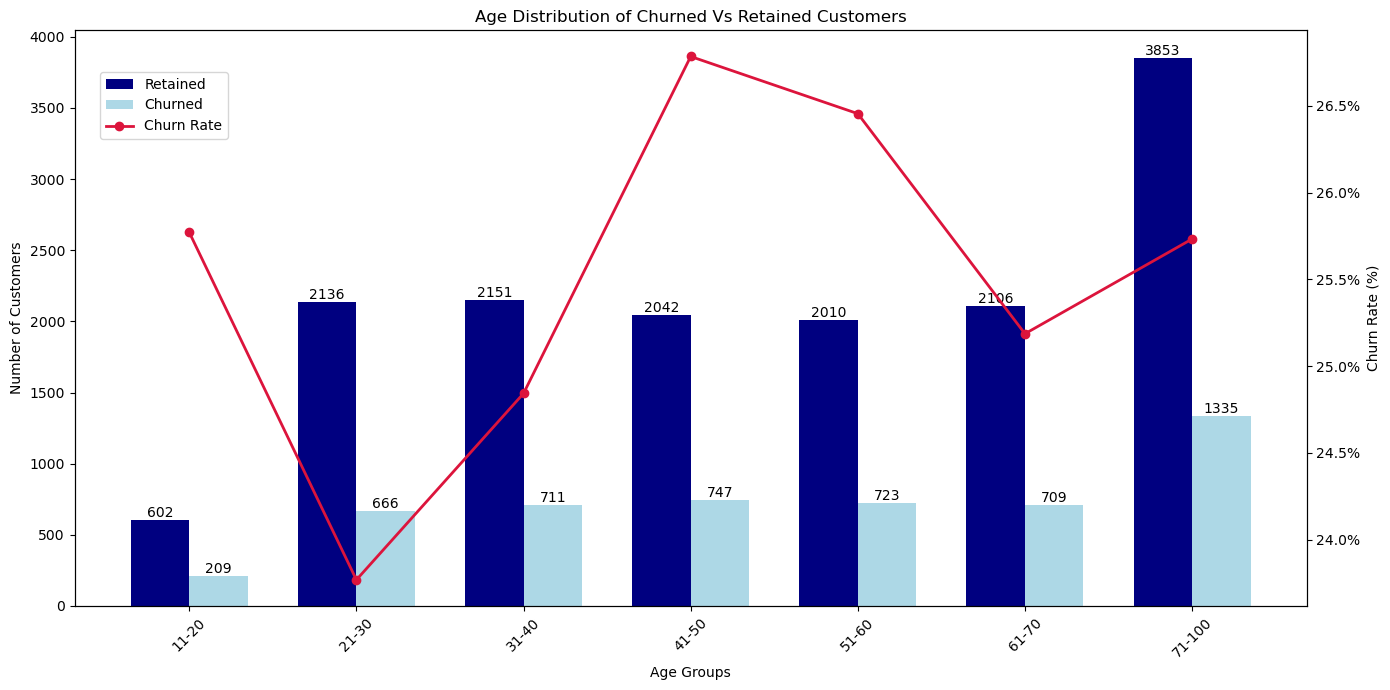

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter


# Ensure the AGE column exists and create the 'Age Group' column
df['Age Group'] = pd.cut(df['AGE'], bins=[0, 20, 30, 40, 50, 60, 70, 100],
                         labels=['11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-100'])

# Group by 'Age Group' and 'Churned', then count the number of occurrences
grouped_data = df.groupby(['Age Group', 'CHURNED']).size().unstack(fill_value=0)

# Calculate churn rate (Churned / Total)
grouped_data['Churn Rate'] = grouped_data[1] / (grouped_data[0] + grouped_data[1])

# Create the clustered bar chart
fig, ax1 = plt.subplots(figsize=(14, 7))
bar_width = 0.35
index = np.arange(len(grouped_data))

# Plot the bars for Not Churned and Churned customers
bars1 = ax1.bar(index - bar_width/2, grouped_data[0], bar_width, label='Retained', color='navy')
bars2 = ax1.bar(index + bar_width/2, grouped_data[1], bar_width, label='Churned', color='lightblue')

# Annotate the bars with values in normal format
def annotate_bars(bars):
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

annotate_bars(bars1)
annotate_bars(bars2)

# Create secondary y-axis for churn rate
ax2 = ax1.twinx()
line, = ax2.plot(index, grouped_data['Churn Rate'], color='crimson', marker='o', linestyle='-', linewidth=2, label='Churn Rate')

# Add custom formatter to the secondary y-axis
def percent_formatter(x, pos):
    return f'{x * 100:.1f}%'

ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Add labels and title
ax1.set_xlabel('Age Groups')
ax1.set_ylabel('Number of Customers')
ax2.set_ylabel('Churn Rate (%)')  # Update y-axis label to indicate percentage
plt.title('Age Distribution of Churned Vs Retained Customers')

# Set the x-ticks to the age groups
ax1.set_xticks(index)
ax1.set_xticklabels(grouped_data.index, rotation=45)

# Create legends inside the graph on the left side
# Manually set the position of the legend
handles, labels = ax1.get_legend_handles_labels()
handles.append(line)  # Add the churn rate line to the legend
labels.append('Churn Rate')  # Add the churn rate label

# Define a new axis for the legend
legend_box = fig.add_axes([0.07, 0.7, 0.2, 0.2])  # [left, bottom, width, height]
legend_box.axis('off')  # Hide the axis

# Add legends to the new axis
legend_box.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

# Adjust layout to ensure all labels and legends are displayed properly
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('age_distribution_churn.png', format='png', bbox_inches='tight')

# Show the chart
plt.show()


## 2)Gender Breakdown Pie Chart: Is there a significant difference in churn rates between genders?

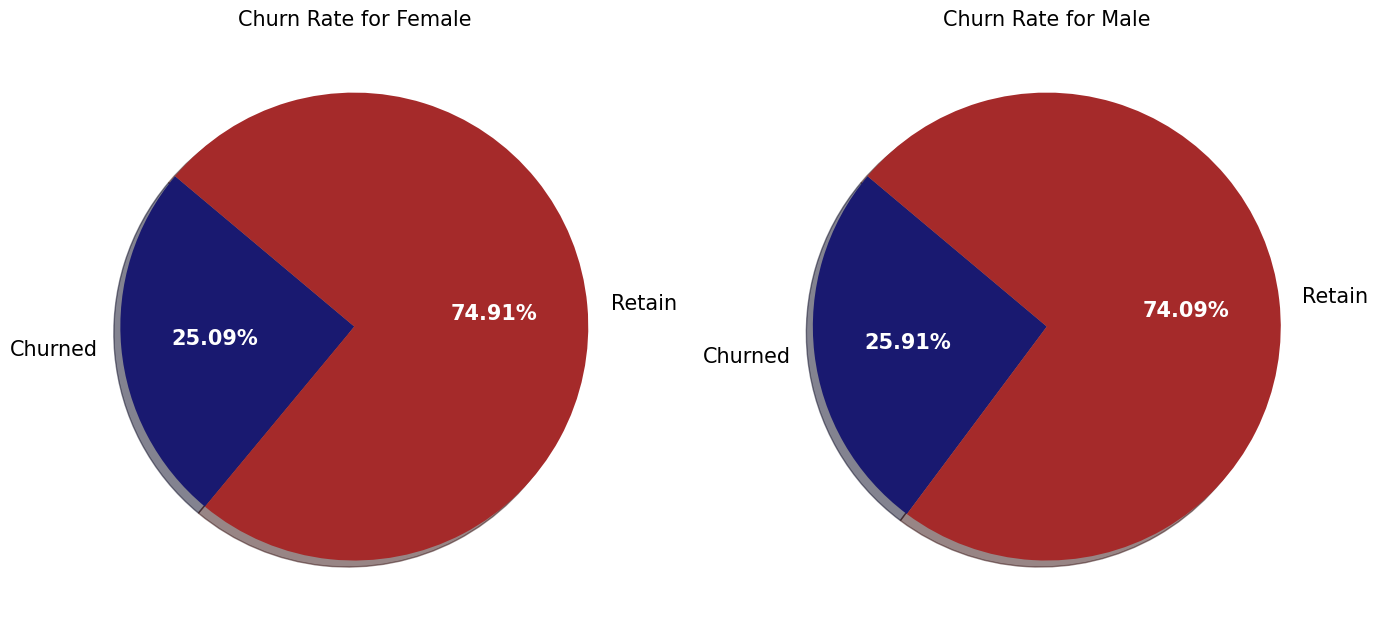

In [11]:
import pandas as pd
import matplotlib.pyplot as plt



gender_map = {0: 'Female', 1: 'Male'}
df['Gender Label'] = df['GENDER'].map(gender_map)


gender_churn = df.groupby('Gender Label')['CHURNED'].mean().reset_index()
gender_churn.columns = ['Gender', 'Churn Rate']


churned_counts = df.groupby(['Gender Label', 'CHURNED']).size().unstack(fill_value=0)
churned_counts['Total'] = churned_counts.sum(axis=1)
churned_counts['Churn Rate'] = churned_counts[1] / churned_counts['Total']


fig, axes = plt.subplots(nrows=1, ncols=len(gender_churn['Gender']), figsize=(14, 7))
if len(gender_churn['Gender']) == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one subplot

for ax, gender in zip(axes, gender_churn['Gender']):
   
    data = churned_counts.loc[gender]
    

    labels = ['Churned', 'Retain']
    sizes = [data[1], data[0]]
    

    wedges, texts, autotexts = ax.pie(
        sizes, labels=labels, autopct='%1.2f%%', colors=['midnightblue', 'brown'],
        startangle=140, shadow=True
    )
    ax.set_title(f'Churn Rate for {gender}', size=15)
    plt.setp(autotexts, size=15, weight="bold",color='white')
    plt.setp(texts, size=15)


plt.tight_layout()


plt.savefig('churn_rate_by_gender.png', format='png', bbox_inches='tight')


plt.show()


## 3) City  Churn Rates Bar Chart: Are there specific cities  with higher churn rates?

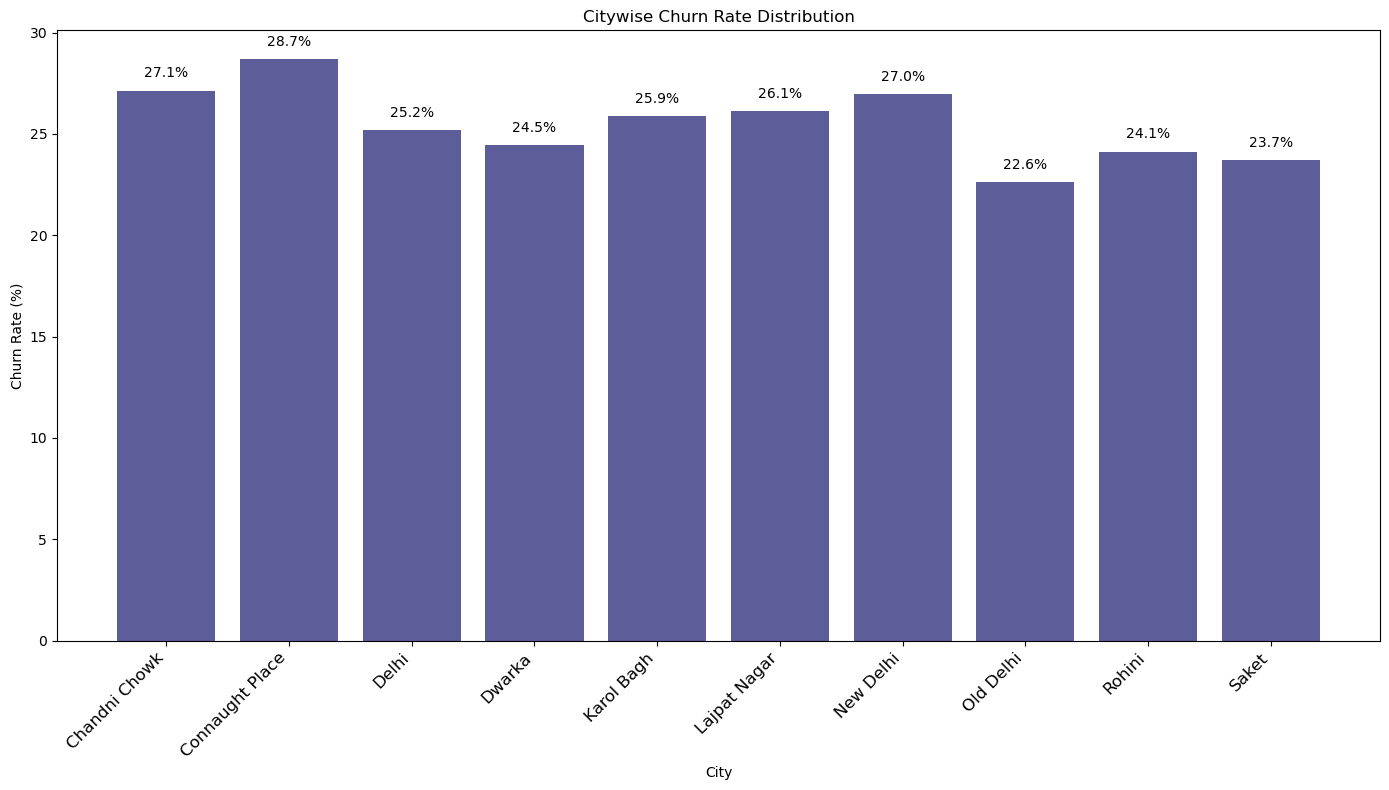

In [12]:

# Check if the conversion is successful
if df['CHURNED'].isnull().any():
    raise ValueError("Conversion of 'CHURNED' column to numeric values failed. Check the column for unexpected values.")


df.dropna(subset=['CHURNED', 'CITY'], inplace=True)


df['CITY'] = df['CITY'].astype(str)


city_churn_rates = df.groupby('CITY')['CHURNED'].mean() * 100  # Multiply by 100 to get percentage
city_churn_rates = city_churn_rates.reset_index()
city_churn_rates.columns = ['City', 'Churn Rate (%)']


plt.figure(figsize=(14, 8))


bars = plt.bar(city_churn_rates['City'], city_churn_rates['Churn Rate (%)'], color='midnightblue', alpha=0.7)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.5, f'{height:.1f}%', ha='center', va='bottom',size=10)


plt.title('Citywise Churn Rate Distribution')
plt.xlabel('City')
plt.ylabel('Churn Rate (%)')


plt.xticks(rotation=45, ha='right', size=12)


plt.tight_layout()


plt.savefig('churn_rate_by_city.png', format='png', dpi=300)

# Show the plot
plt.show()


## 4)Usage Patterns Bar Chart (Data, Text, Voice): How do data, text, and voice usage patterns differ between churned and retained customers?

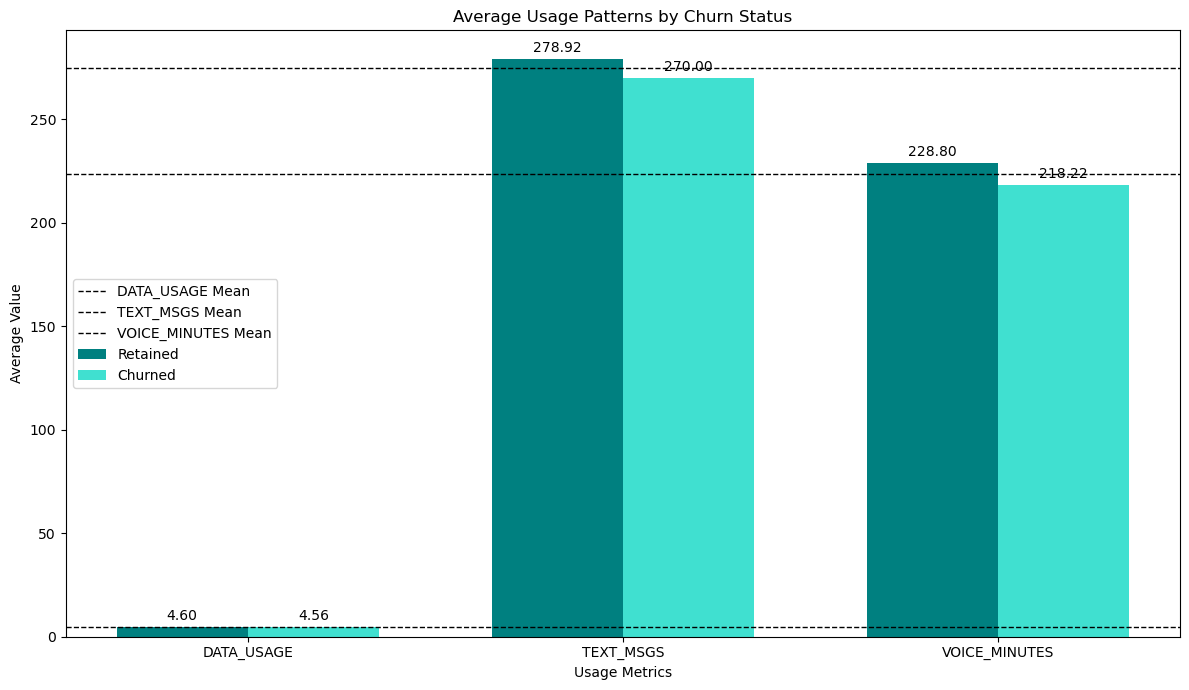

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Calculate average usage metrics for churned and retained customers
usage_data = df.groupby('CHURNED').agg({
    'DATA_USAGE': 'mean',
    'TEXT_MSGS': 'mean',
    'VOICE_MINUTES': 'mean'
}).reset_index()


usage_data.rename(columns={'CHURNED': 'Churn Status'}, inplace=True)
usage_data.set_index('Churn Status', inplace=True)


fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(usage_data.columns))


bar1 = ax.bar(index - bar_width / 2, usage_data.loc[0], bar_width, label='Retained', color='teal')
bar2 = ax.bar(index + bar_width / 2, usage_data.loc[1], bar_width, label='Churned', color='turquoise')


mean_values = usage_data.mean(axis=0)
for i, metric in enumerate(usage_data.columns):
    ax.axhline(y=mean_values[metric], color='black', linestyle='--', linewidth=1, label=f'{metric} Mean')


ax.set_xlabel('Usage Metrics')
ax.set_ylabel('Average Value')
ax.set_title('Average Usage Patterns by Churn Status')
ax.set_xticks(index)
ax.set_xticklabels(usage_data.columns)
ax.legend(loc='best')


def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bar1)
annotate_bars(bar2)


plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('usage_patterns_by_churn_status_with_mean.png', format='png', bbox_inches='tight')

# Show the chart
plt.show()


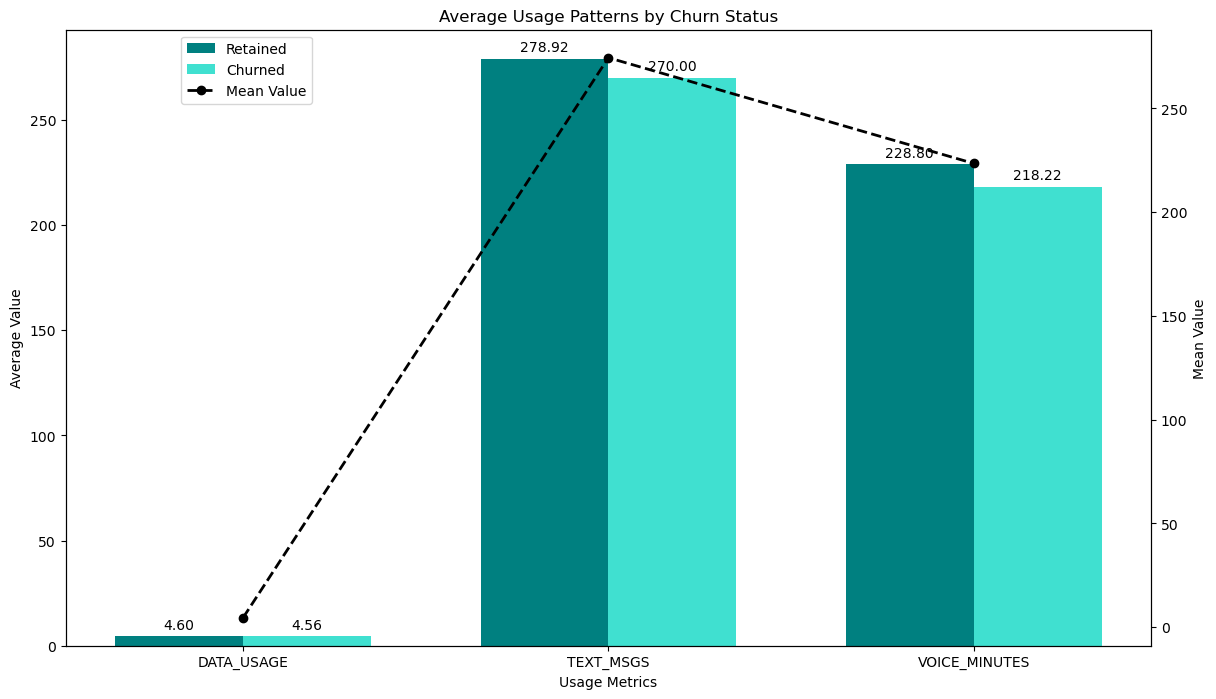

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



usage_data = df.groupby('CHURNED').agg({
    'DATA_USAGE': 'mean',
    'TEXT_MSGS': 'mean',
    'VOICE_MINUTES': 'mean'
}).reset_index()


usage_data.rename(columns={'CHURNED': 'Churn Status'}, inplace=True)
usage_data.set_index('Churn Status', inplace=True)


fig, ax1 = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(usage_data.columns))


bars_retained = ax1.bar(index - bar_width / 2, usage_data.loc[0], bar_width, label='Retained', color='teal')
bars_churned = ax1.bar(index + bar_width / 2, usage_data.loc[1], bar_width, label='Churned', color='turquoise')


ax2 = ax1.twinx()
mean_values = usage_data.mean(axis=0)
ax2.plot(index, mean_values, color='black', marker='o', linestyle='--', linewidth=2, label='Mean Value')


ax1.set_xlabel('Usage Metrics')
ax1.set_ylabel('Average Value')
ax2.set_ylabel('Mean Value')
ax1.set_title('Average Usage Patterns by Churn Status')


ax1.set_xticks(index)
ax1.set_xticklabels(usage_data.columns)


handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


handles.extend(handles2)
labels.extend(labels2)

# Place legends inside the plot
ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 1.0))

# Annotate bars with values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars_retained)
annotate_bars(bars_churned)

# Save the plot as a PNG file
plt.savefig('usage_patterns_with_combined_legend2.png', format='png', bbox_inches='tight')

# Show the chart
plt.show()


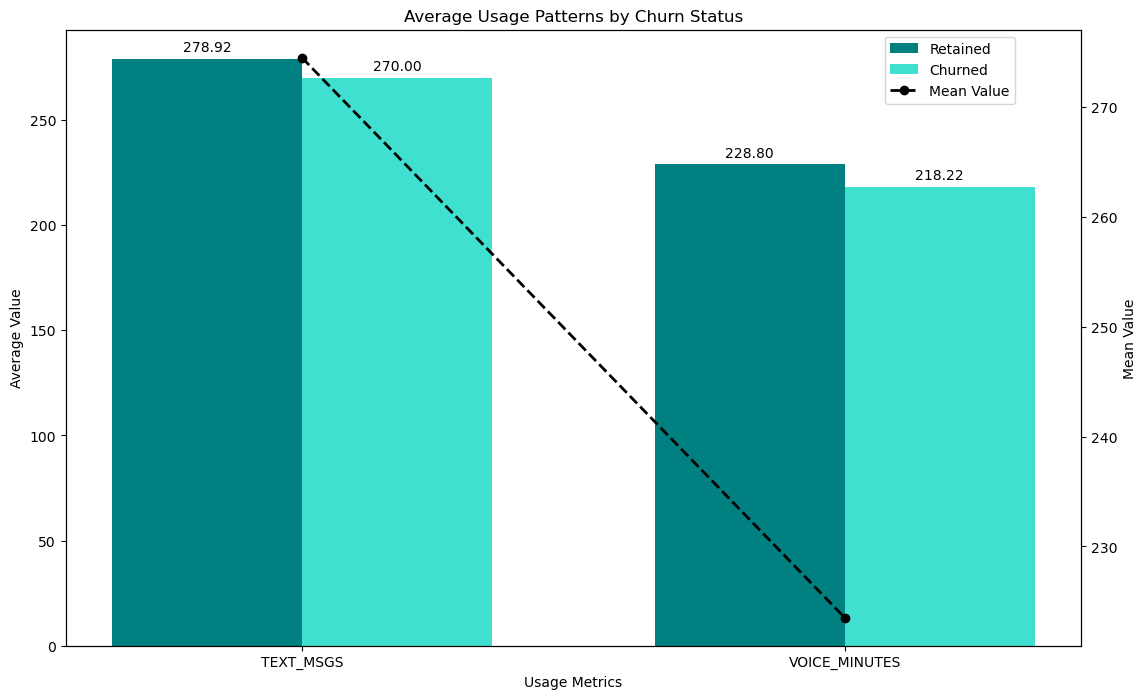

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




usage_data = df.groupby('CHURNED').agg({
    'TEXT_MSGS': 'mean',
    'VOICE_MINUTES': 'mean'
}).reset_index()

# Rename churn column for clarity
usage_data.rename(columns={'CHURNED': 'Churn Status'}, inplace=True)
usage_data.set_index('Churn Status', inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(usage_data.columns))

# Plot bars for churned and retained customers
bars_retained = ax1.bar(index - bar_width / 2, usage_data.loc[0], bar_width, label='Retained', color='teal')
bars_churned = ax1.bar(index + bar_width / 2, usage_data.loc[1], bar_width, label='Churned', color='turquoise')

# Create secondary y-axis for the mean line
ax2 = ax1.twinx()
mean_values = usage_data.mean(axis=0)
ax2.plot(index, mean_values, color='black', marker='o', linestyle='--', linewidth=2, label='Mean Value')

# Add labels and title
ax1.set_xlabel('Usage Metrics')
ax1.set_ylabel('Average Value')
ax2.set_ylabel('Mean Value')
ax1.set_title('Average Usage Patterns by Churn Status')

# Set x-ticks and labels
ax1.set_xticks(index)
ax1.set_xticklabels(usage_data.columns)

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.85)  # Increase right margin slightly to avoid clipping

# Add legends inside the plot area, to the right
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine legends
handles.extend(handles2)
labels.extend(labels2)

# Place legend inside the plot area, on the right side
ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.80, 1))

# Annotate bars with values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars_retained)
annotate_bars(bars_churned)

# Save the plot as a PNG file
plt.savefig('Average Usage Patterns by churn status.png', format='png', bbox_inches='tight')

# Show the chart
plt.show()


## Year Wise churn rate

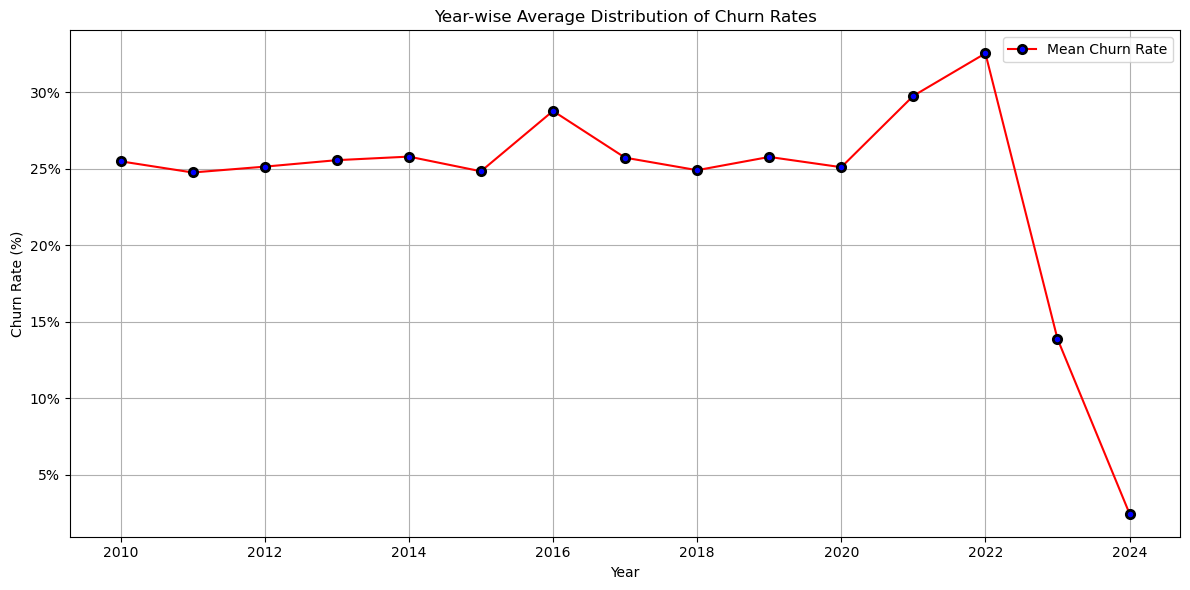

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Your existing code to process the DataFrame
if 'CUSTOMER_SINCE' in df.columns:
    df['CUSTOMER_SINCE'] = pd.to_datetime(df['CUSTOMER_SINCE'])

df['Churn_Year'] = df['CUSTOMER_SINCE'].dt.year
df['Churned_Binary'] = df['CHURNED'].apply(lambda x: 1 if x == 'Yes' else 0)
yearly_churn = df.groupby('Churn_Year')['Churned_Binary'].agg(['mean', 'median', 'sum', 'count'])
yearly_churn.columns = ['Mean Churn Rate', 'Median Churn Rate', 'Total Churned', 'Total Customers']
yearly_churn['Churn Rate (%)'] = yearly_churn['Mean Churn Rate'] * 100

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean churn rate
plt.plot(yearly_churn.index, yearly_churn['Mean Churn Rate'], 
         label='Mean Churn Rate', 
         color='red',          # Line color
         linestyle='-',       # Line style
         marker='o',          # Marker style
         markerfacecolor='blue', # Color of the dots
         markeredgewidth=2,   # Width of the edge around the marker
         markeredgecolor='black')

# Add custom formatter to the y-axis
def percent_formatter(x, pos):
    return f'{x * 100:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Adding titles and labels
plt.title('Year-wise Average Distribution of Churn Rates')
plt.xlabel('Year')
plt.ylabel('Churn Rate (%)')  # Update y-axis label to indicate percentage
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.savefig('yearly_churn_rates.png', format='png', dpi=300)
plt.show()


## 5)How does the distribution of customer tenure (in months) vary across different customer segments, namely 'corporate', 'family', and 'individual'?

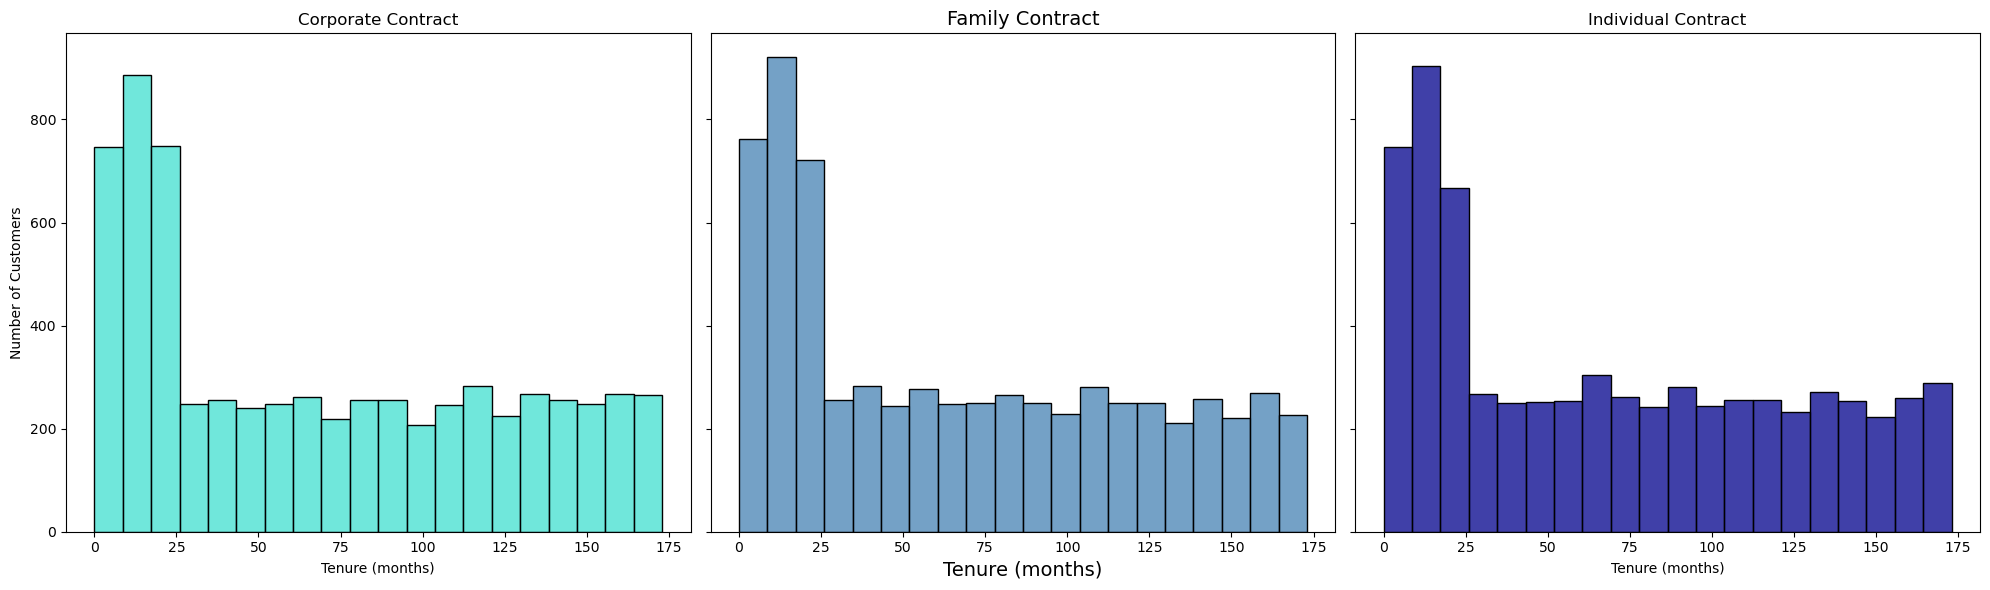

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

# Plot for 'corporate' segment
sns.histplot(df[df['CUSTOMER_SEGMENT'] == 'corporate']['TENURE'],
             bins=int(100/5), color='turquoise',
             edgecolor='black', ax=ax1)
ax1.set_ylabel('Number of Customers')
ax1.set_xlabel('Tenure (months)')
ax1.set_title('Corporate Contract')

# Plot for 'family' segment
sns.histplot(df[df['CUSTOMER_SEGMENT'] == 'family']['TENURE'],
             bins=int(100/5), color='steelblue',
             edgecolor='black', ax=ax2)
ax2.set_xlabel('Tenure (months)', size=14)
ax2.set_title('Family Contract', size=14)

# Plot for 'individual' segment
sns.histplot(df[df['CUSTOMER_SEGMENT'] == 'individual']['TENURE'],
             bins=int(100/5), color='darkblue',
             edgecolor='black', ax=ax3)
ax3.set_xlabel('Tenure (months)')
ax3.set_title('Individual Contract')

# Adjust layout
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('SEGMENT DISTRIBUTION.png', format='png', bbox_inches='tight')
plt.show()


## 2. Account Information

## 1) Customer Since vs. Churn Scatter Plot: Do customers with older accounts churn less frequently?

C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_29836\2491491671.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CUSTOMER_SINCE'] = pd.to_datetime(df['CUSTOMER_SINCE'], errors='coerce')


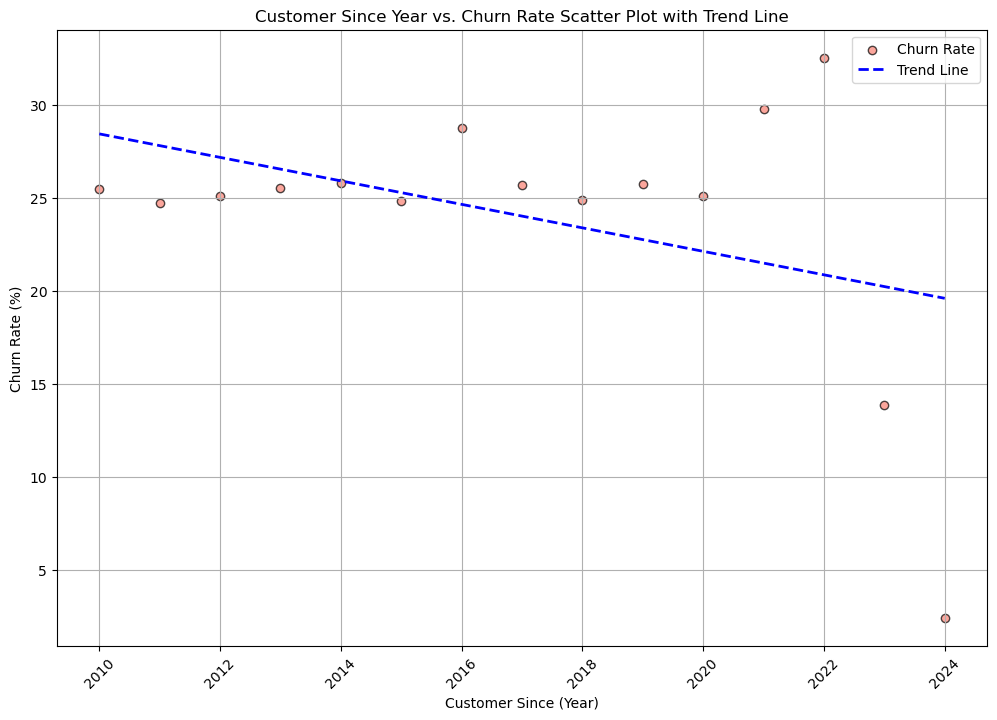

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter



# Convert 'Customer Since' to datetime format
df['CUSTOMER_SINCE'] = pd.to_datetime(df['CUSTOMER_SINCE'], errors='coerce')

# Remove rows with NaT values in 'CUSTOMER_SINCE'
df = df.dropna(subset=['CUSTOMER_SINCE'])

# Extract the year from 'Customer Since'
df['Customer Since (Year)'] = df['CUSTOMER_SINCE'].dt.year

# Encode the 'CHURNED' column if it's not already in numeric form
df['CHURNED'] = df['CHURNED'].map({'Yes': 1, 'No': 0})  # Convert churn status to numeric format

# Calculate churn rate by 'Customer Since (Year)'
churn_rate_by_year = df.groupby('Customer Since (Year)')['CHURNED'].mean() * 100

# Prepare data for the trend line
X = churn_rate_by_year.index.values.reshape(-1, 1)
y = churn_rate_by_year.values

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict churn rates for the trend line
y_pred = model.predict(X)

# Plotting the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(churn_rate_by_year.index, churn_rate_by_year.values, color='salmon', edgecolor='k', alpha=0.7, label='Churn Rate')

# Plotting the trend line
plt.plot(churn_rate_by_year.index, y_pred, color='blue', linestyle='--', linewidth=2, label='Trend Line')

# Formatting the plot
plt.title('Customer Since Year vs. Churn Rate Scatter Plot with Trend Line')
plt.xlabel('Customer Since (Year)')
plt.ylabel('Churn Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability



# Show legend
plt.legend()

# Save the plot
plt.savefig('customer_since_year_vs_churn_rate_scatter_with_trend.png', format='png', dpi=300)

# Show the plot
plt.show()


## 2) Customer Type Bar Chart: Which customer types (postpaid/prepaid) have the highest churn rates?

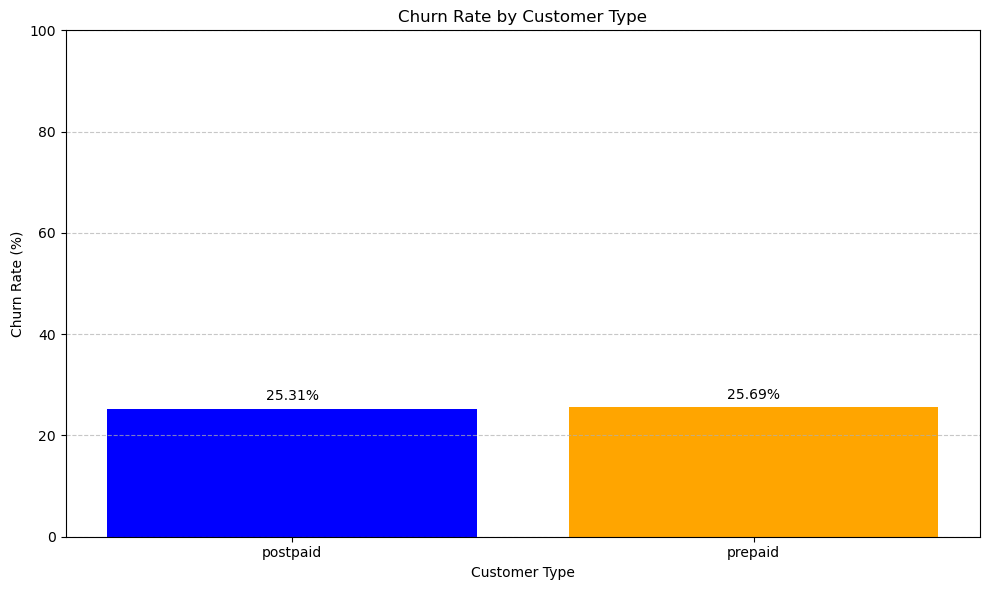

In [22]:
import pandas as pd
import matplotlib.pyplot as plt




churn_rate_by_type = df.groupby('CUSTOMER_TYPE')['Churned_Binary'].mean() * 100
churn_rate_by_type = churn_rate_by_type.reset_index()
churn_rate_by_type.columns = ['Customer_Type', 'Churn_Rate (%)']


plt.figure(figsize=(10, 6))


bars = plt.bar(churn_rate_by_type['Customer_Type'], churn_rate_by_type['Churn_Rate (%)'], color=['blue', 'orange'])


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Adding titles and labels
plt.title('Churn Rate by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)  # Set y-axis limits from 0% to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.savefig('churn_rate_by_customer_type.png', format='png', dpi=300)
plt.show()




## 3)Tenure Distribution Histogram: How does the tenure of churned customers compare to retained customers?

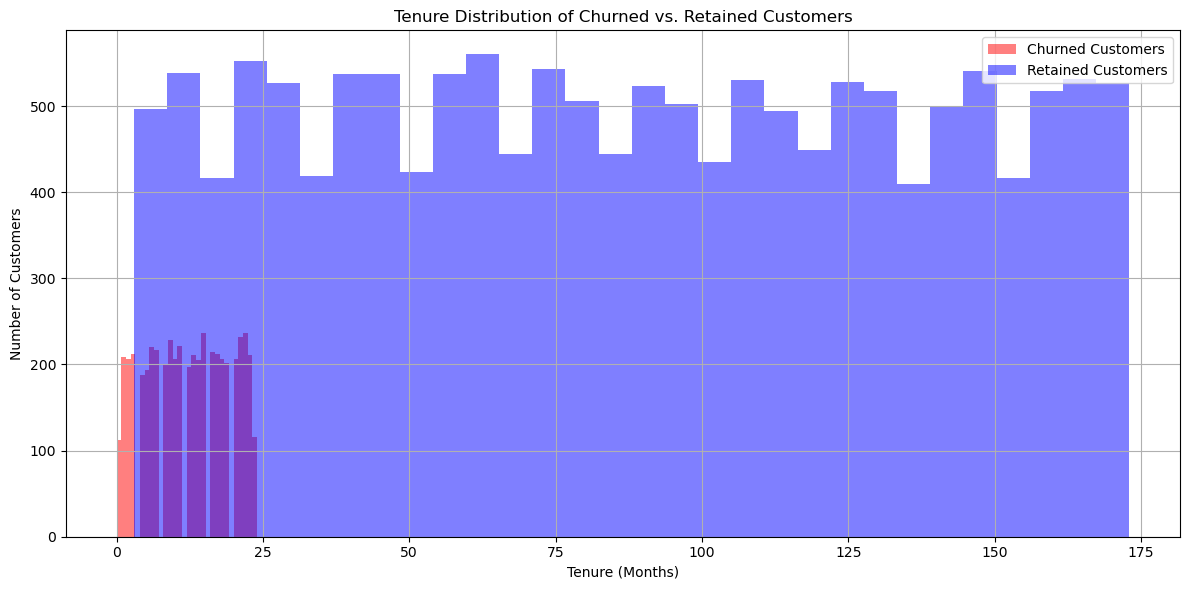

In [23]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting
plt.figure(figsize=(12, 6))

# Plot histograms for churned and retained customers
plt.hist(churned_customers['TENURE'], bins=30, alpha=0.5, label='Churned Customers', color='red')
plt.hist(retained_customers['TENURE'], bins=30, alpha=0.5, label='Retained Customers', color='blue')

# Adding titles and labels
plt.title('Tenure Distribution of Churned vs. Retained Customers')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.legend(loc='upper right')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.savefig('tenure_distribution_comparison.png', format='png', dpi=300)
plt.show()


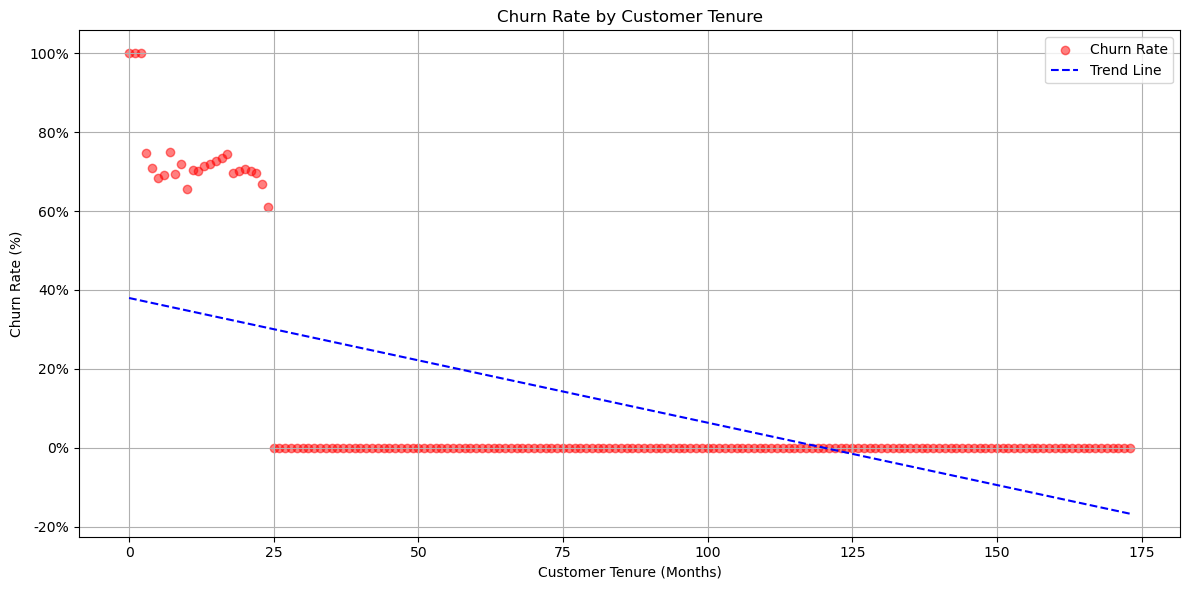

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter



# Drop rows where 'TENURE' or 'Churned_Binary' is NaN
df.dropna(subset=['TENURE', 'Churned_Binary'], inplace=True)

# Group by tenure and calculate average churn rate
churn_by_tenure = df.groupby('TENURE')['Churned_Binary'].mean().reset_index()

# Convert churn rate to percentage
churn_by_tenure['Churn Rate (%)'] = churn_by_tenure['Churned_Binary'] * 100

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot with trend line
plt.scatter(churn_by_tenure['TENURE'], churn_by_tenure['Churn Rate (%)'], 
            label='Churn Rate', color='red', alpha=0.5)
m, b = np.polyfit(churn_by_tenure['TENURE'], churn_by_tenure['Churn Rate (%)'], 1)
plt.plot(churn_by_tenure['TENURE'], m * churn_by_tenure['TENURE'] + b, 
         color='blue', linestyle='--', label='Trend Line')


def percent_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))


plt.title('Churn Rate by Customer Tenure')
plt.xlabel('Customer Tenure (Months)')
plt.ylabel('Churn Rate (%)')  # Update y-axis label to indicate percentage
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig('churn_rate_by_tenure.png', format='png', dpi=300)
plt.show()


<Axes: xlabel='CHURNED', ylabel='TENURE'>

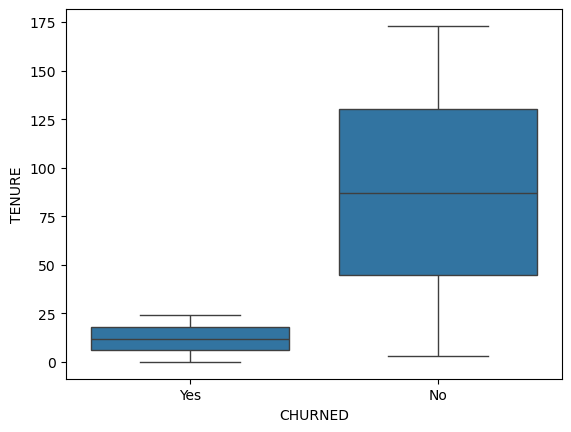

In [258]:
sns.boxplot(x = df.CHURNED, y = df.TENURE)

## 3. Service Information

## 1)Service Utilization Heat Map: Which services are least utilized by churned customers?

Missing values after conversion:
GENDER                     0
AGE                        0
SENIORCITIZEN              0
PARTNER                    0
DEPENDENTS                 0
CITY                       0
CUSTOMER_SINCE             0
CUSTOMER_SEGMENT           0
CUSTOMER_TYPE              0
CUSTOMER_DISCONNCT_DATE    0
CUSTOMER_STATUS            0
TENURE                     0
PHONE_SERVICE              0
MULTIPLE_LINES             0
INTERNET_SERVICE           0
DATA_USAGE                 0
TEXT_MSGS                  0
VOICE_MINUTES              0
MONTHLY_BILL               0
CHURN_REASON               0
CHURNED                    0
dtype: int64


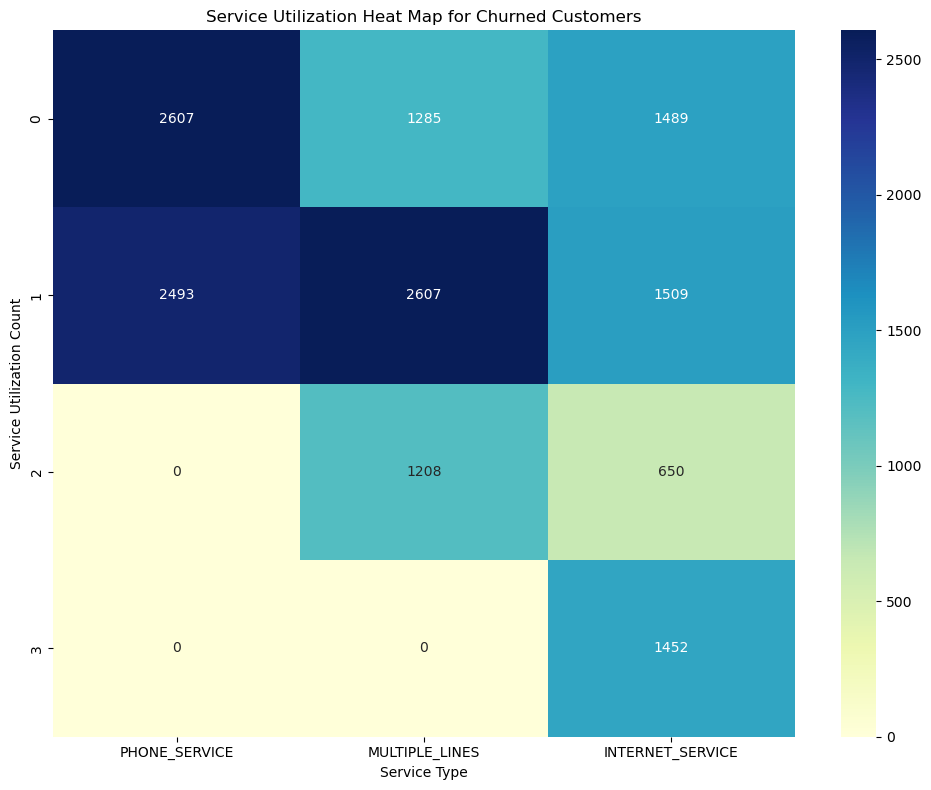

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert specified columns to numeric data types
df['DATA_USAGE'] = pd.to_numeric(df['DATA_USAGE'], errors='coerce')
df['MONTHLY_BILL'] = pd.to_numeric(df['MONTHLY_BILL'], errors='coerce')


# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
df_dummies.head()

# Display columns with missing values after conversion
print("Missing values after conversion:")
print(df.isnull().sum())

#Removing missing values 
df.dropna(inplace = True)



# Filter for churned customers
churned_customers = df[df['CHURNED'] == 1]

# Count occurrences of each service type for churned customers
service_columns = ['PHONE_SERVICE', 'MULTIPLE_LINES', 'INTERNET_SERVICE']
service_utilization = churned_customers[service_columns].apply(pd.Series.value_counts).fillna(0)


# Plotting
plt.figure(figsize=(10, 8))

# Create a heat map
sns.heatmap(service_utilization, annot=True, cmap='YlGnBu', fmt='g', cbar=True)

# Adding titles and labels
plt.title('Service Utilization Heat Map for Churned Customers')
plt.xlabel('Service Type')
plt.ylabel('Service Utilization Count')

# Show the plot
plt.tight_layout()
plt.savefig('service_utilization_heat_map1.png', format='png', dpi=300)
plt.show()


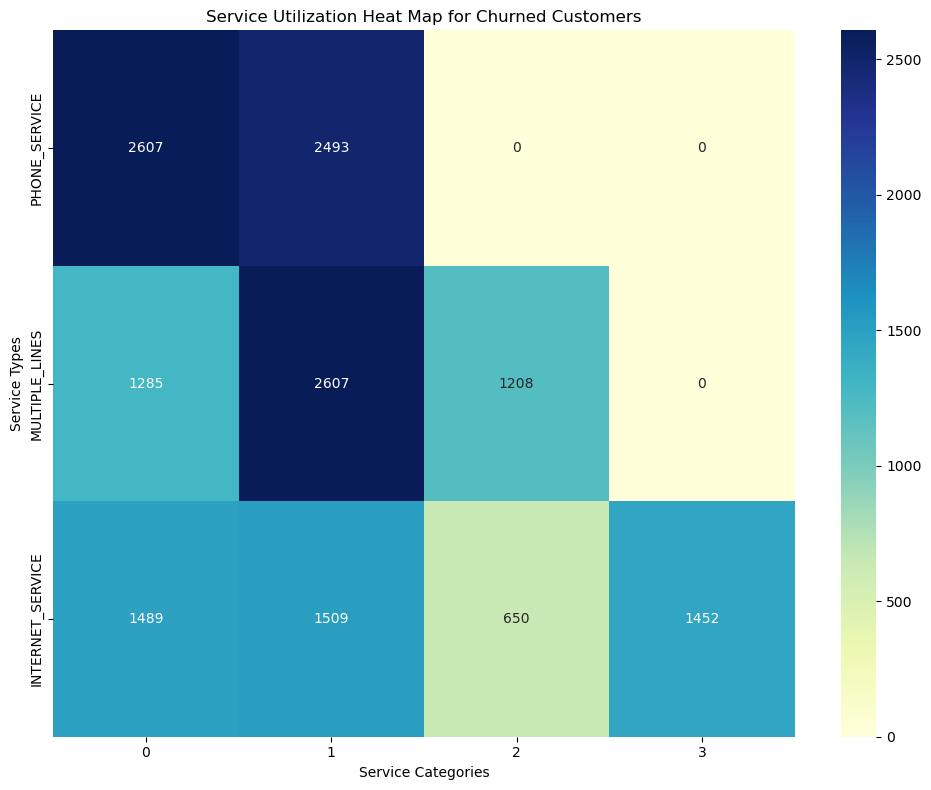

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder




# Filter for churned customers
churned_customers = df[df['CHURNED'] == 1]

# Count occurrences of each service type for churned customers
service_columns = ['PHONE_SERVICE', 'MULTIPLE_LINES', 'INTERNET_SERVICE']
service_counts = churned_customers[service_columns].apply(pd.Series.value_counts).fillna(0)

# Transpose the service counts for better visualization
service_counts = service_counts.T

# Plotting
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(service_counts, annot=True, cmap='YlGnBu', fmt='g', cbar=True)

# Adding titles and labels
plt.title('Service Utilization Heat Map for Churned Customers')
plt.xlabel('Service Categories')
plt.ylabel('Service Types')

# Show the plot
plt.tight_layout()
plt.savefig('service_utilization_heat_map1.png', format='png', dpi=300)
plt.show()


## 2) Service Plan Comparison Bar Chart: Do certain service plans (e.g., multiple lines, internet service) have higher churn rates?

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


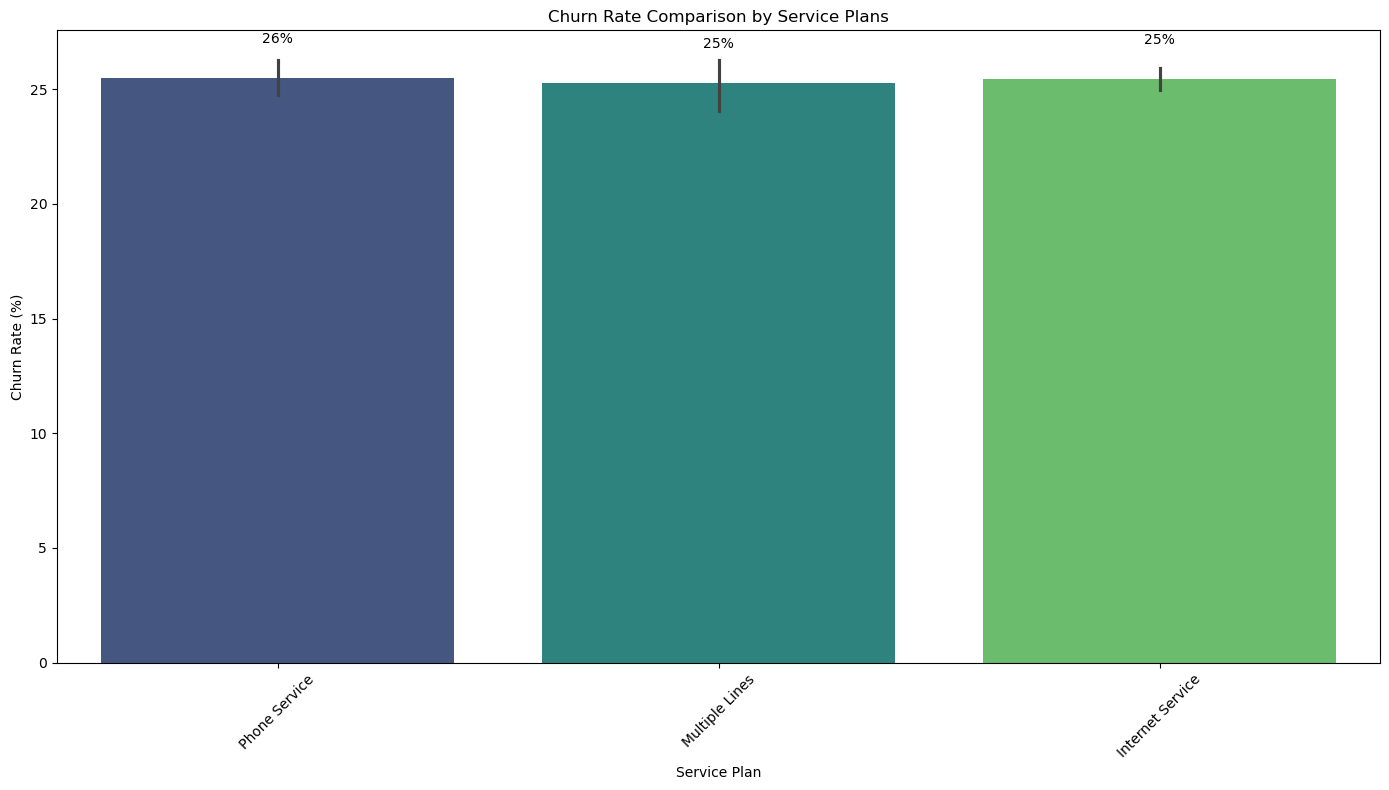

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



# Function to calculate churn rates
def calculate_churn_rates(df, service_column):
    # Calculate the mean of churned customers per service plan
    churn_rate = df.groupby(service_column, observed=True)['CHURNED'].mean() * 100  # Multiply by 100 to get percentage
    return churn_rate

# Service columns to analyze
service_columns = ['PHONE_SERVICE', 'MULTIPLE_LINES', 'INTERNET_SERVICE']

# Initialize an empty DataFrame to store churn rates
churn_rates_df = pd.DataFrame()

# Iterate through each service column and calculate churn rates
for service in service_columns:
    churn_rate = calculate_churn_rates(df, service)
    churn_rate_df = churn_rate.reset_index()
    churn_rate_df.columns = [service, 'Churn Rate (%)']
    
    # Map the encoded service plan values back to their original names
    if service == 'PHONE_SERVICE':
        service_plan_mapping = {0: 'No Phone Service', 1: 'Phone Service'}
    elif service == 'MULTIPLE_LINES':
        service_plan_mapping = {0: 'No Multiple Lines', 1: 'Multiple Lines'}
    elif service == 'INTERNET_SERVICE':
        service_plan_mapping = {0: 'No Internet Service', 1: 'Internet Service'}
    
    # Replace the encoded values with their original labels
    churn_rate_df[service] = churn_rate_df[service].replace(service_plan_mapping)
    
    # Add a column to identify the service type
    churn_rate_df['Service Type'] = service.replace('_', ' ').title()
    
    # Append to the main DataFrame
    churn_rates_df = pd.concat([churn_rates_df, churn_rate_df], axis=0)

# Plotting
plt.figure(figsize=(14, 8))

# Create a bar plot
ax = sns.barplot(x='Service Type', y='Churn Rate (%)', hue='Service Type', data=churn_rates_df, dodge=False, palette='viridis')

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}%', 
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 23),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Adding titles and labels
plt.title('Churn Rate Comparison by Service Plans')
plt.xlabel('Service Plan')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability



# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('churn_rate_comparison_service_plans.png', format='png', dpi=300)

# Show the plot
plt.show()


## 4. Customer Interaction

## 1)Churn Reason Bar Chart: What are the most common reasons for churn?

C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_8408\555913782.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Churn Reason', data=churn_reason_df, palette='viridis')


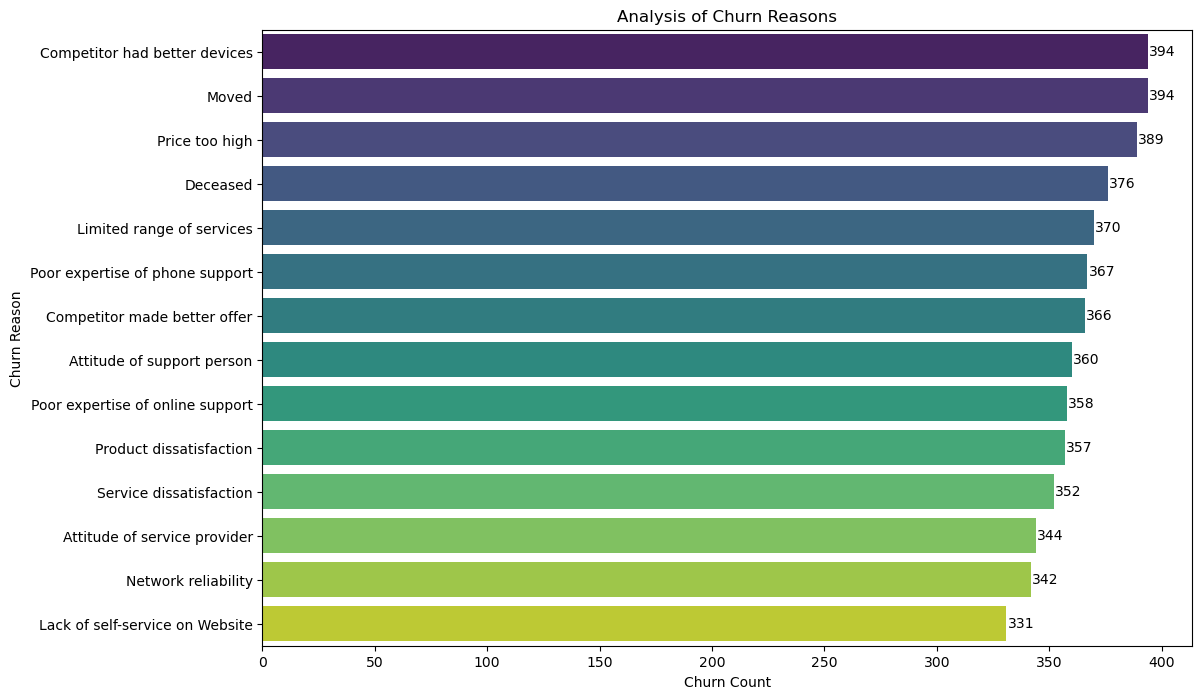

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Filter the DataFrame to include only rows where CHURNED is 1
filtered_df = df[df['CHURNED'] == 'Yes']

# Count the occurrences of each churn reason in the filtered data
churn_reason_counts = filtered_df['CHURN_REASON'].value_counts()

# Convert the counts to a DataFrame for easier plotting
churn_reason_df = churn_reason_counts.reset_index()
churn_reason_df.columns = ['Churn Reason', 'Count']

# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Count', y='Churn Reason', data=churn_reason_df, palette='viridis')

# Annotate each bar with the count value without decimal places
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}',  # Convert width to integer
                (width + 0.5, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10, color='black')

plt.title('Analysis of Churn Reasons')
plt.xlabel('Churn Count')
plt.ylabel('Churn Reason')
# Save the plot as a PNG file
plt.savefig('Churn Reason.png', format='png', bbox_inches='tight')
plt.show()


## 2)Customer Status Pie Chart: What proportion of customers are active versus inactive?

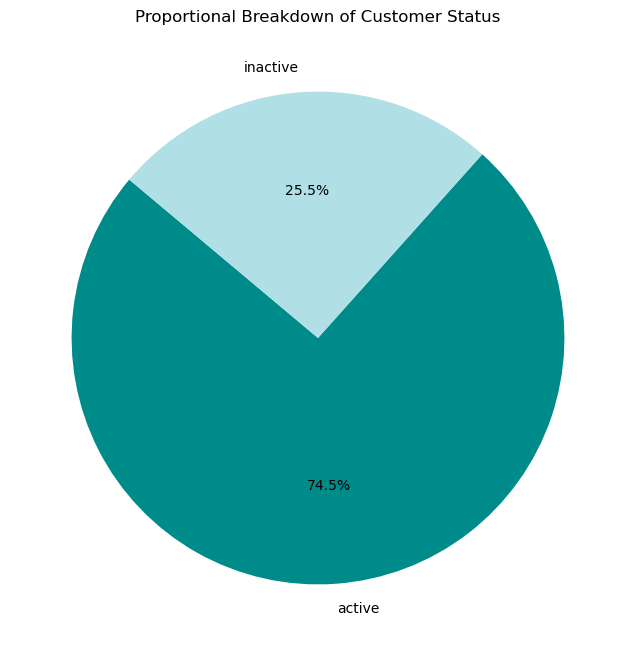

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the occurrences of each customer status
status_counts = df['CUSTOMER_STATUS'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['darkcyan', 'powderblue'], startangle=140)
plt.title('Proportional Breakdown of Customer Status')
# Save the plot as a PNG file
plt.savefig('Proportional Breakdown of Customer Status.png', format='png', bbox_inches='tight')
plt.show()


## 5. Behavioural Data

## 1)Engagement Metrics Bar Chart: How do engagement metrics (data usage, text messages, voice minutes) differ between churned and retained customers?

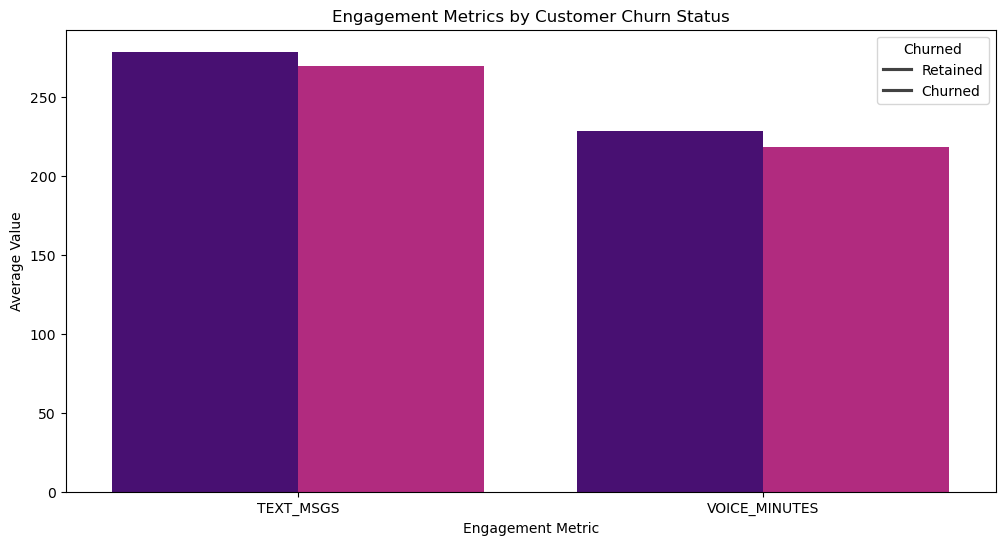

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by churn status and calculate mean values for engagement metrics
engagement_metrics = df.groupby('CHURNED')[[ 'TEXT_MSGS', 'VOICE_MINUTES']].mean().reset_index()
engagement_metrics = engagement_metrics.melt(id_vars='CHURNED', var_name='Metric', value_name='Average')

# Define a custom color palette
# You can specify colors for '0' and '1' churn statuses
custom_palette = {'No': 'indigo', 'Yes': 'mediumvioletred'}

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Average', hue='CHURNED', data=engagement_metrics, palette=custom_palette)

# Add labels and title
plt.title('Engagement Metrics by Customer Churn Status')
plt.xlabel('Engagement Metric')
plt.ylabel('Average Value')
plt.legend(title='Churned', labels=['Retained', 'Churned'])
# Save the plot as a PNG file
plt.savefig('Engagement Metrics by customer churn status.png', format='png', bbox_inches='tight')
# Display the plot
plt.show()


## 2)	Usage Over Time Line Graph: How does usage change over time for churned versus retained customers?

## 3)How do the distributions of monthly charges differ between customers who have churned and those who have not churned

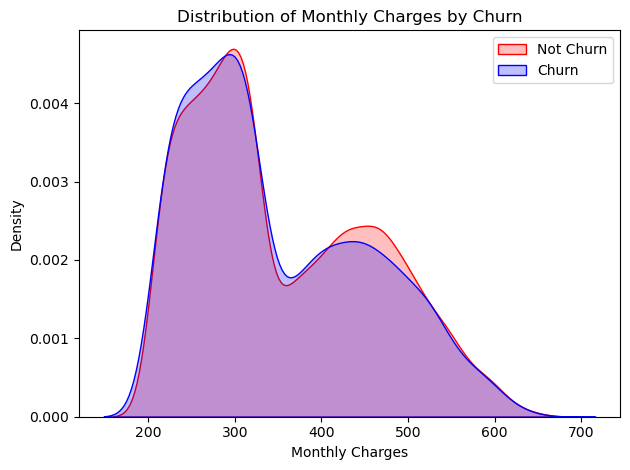

In [37]:

# Plot KDE for 'Not Churn' and 'Churn'
ax = sns.kdeplot(df.MONTHLY_BILL[df["CHURNED"] == 'No'],
                 color="Red", fill=True)
ax = sns.kdeplot(df.MONTHLY_BILL[df["CHURNED"] == 'Yes'],
                 ax=ax, color="Blue", fill=True)

# Customize plot
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

# Show plot
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('Distribution of monthly charges.png', format='png', bbox_inches='tight')
plt.show()

## 6. Competitive Landscape

## 1)Competitive Churn Reason Analysis Bar Chart: How often are competitor-related reasons cited for churn?

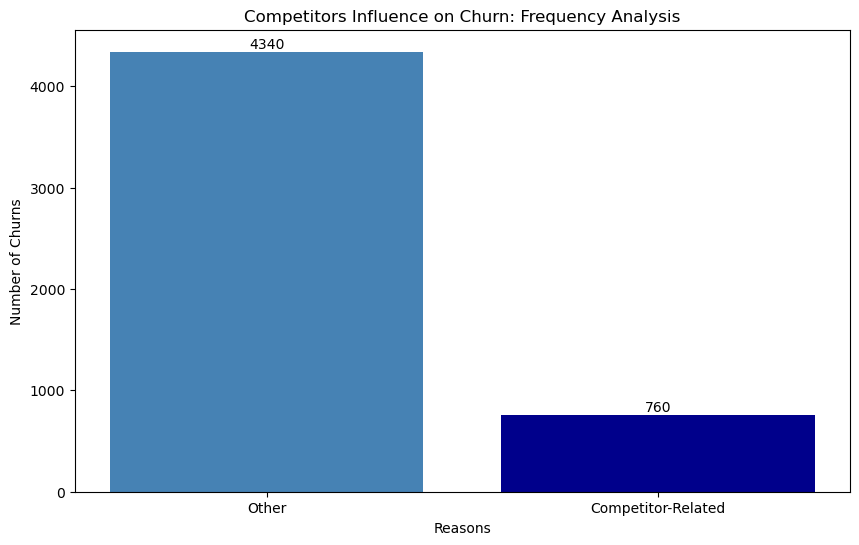

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Define competitor-related reasons
competitor_related_reasons = ['Competitor', 'better offer', 'Cheaper Plan', 'better devices']  # Customize as needed

# Create a column to indicate whether the reason is competitor-related
df_churned.loc[:, 'COMPETITOR_CHURN_REASON'] = df_churned['CHURN_REASON'].apply(
    lambda x: 'Competitor-Related' if any(reason in x for reason in competitor_related_reasons) else 'Other'
)

# Group by churn reason and count occurrences
competitor_churn_counts = df_churned['COMPETITOR_CHURN_REASON'].value_counts().reset_index()
competitor_churn_counts.columns = ['Reason', 'Count']

# Define custom colors for each category
color_mapping = {
    'Competitor-Related': 'darkblue',  # Customize color for 'Competitor-Related'
    'Other': 'steelblue'               # Customize color for 'Other'
}

# Create a color list based on the custom color mapping
colors = [color_mapping[reason] for reason in competitor_churn_counts['Reason']]

# Plot the bar chart with specified colors using matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(competitor_churn_counts['Reason'], competitor_churn_counts['Count'], color=colors)

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height}', ha='center', va='bottom')

# Add labels and title
plt.title('Competitors Influence on Churn: Frequency Analysis')
plt.xlabel('Reasons')
plt.ylabel('Number of Churns')

# Save the plot as a PNG file
plt.savefig('Competitor_Influence_on_Churn_Frequency_Analysis.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()


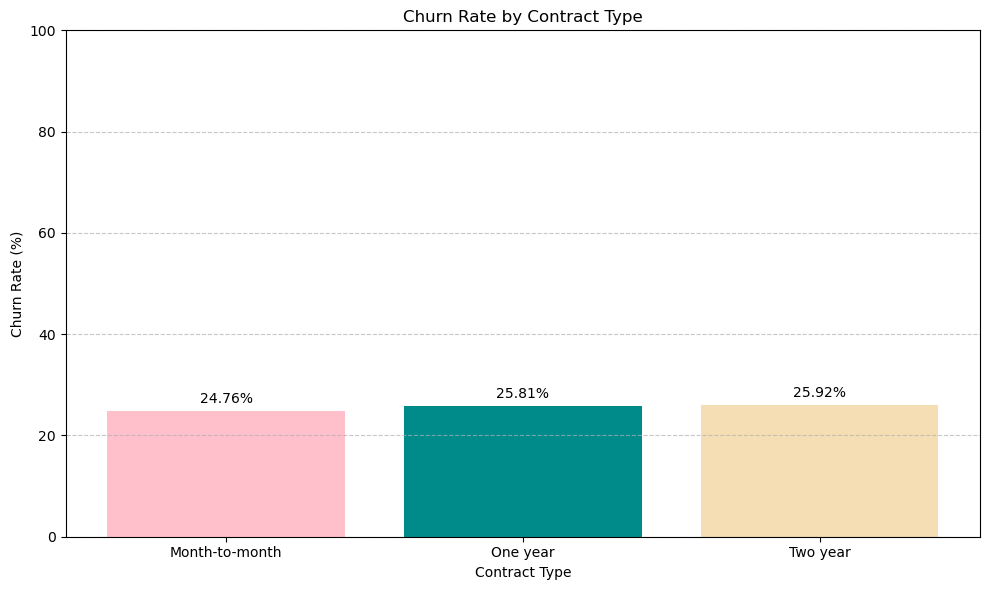

In [52]:


# Group by customer type and calculate churn rates
churn_rate_by_type = df.groupby('Contract')['Churned_Binary'].mean() * 100
churn_rate_by_type = churn_rate_by_type.reset_index()
churn_rate_by_type.columns = ['Contract', 'Churn_Rate (%)']

# Plotting
plt.figure(figsize=(10, 6))

# Create a bar chart for churn rates by customer type
bars = plt.bar(churn_rate_by_type['Contract'], churn_rate_by_type['Churn_Rate (%)'], color=['pink', 'darkcyan', 'wheat'])

# Annotate bars with the churn rate values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Adding titles and labels
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)  # Set y-axis limits from 0% to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.savefig('churn_rate_by_customer_type.png', format='png', dpi=300)
plt.show()




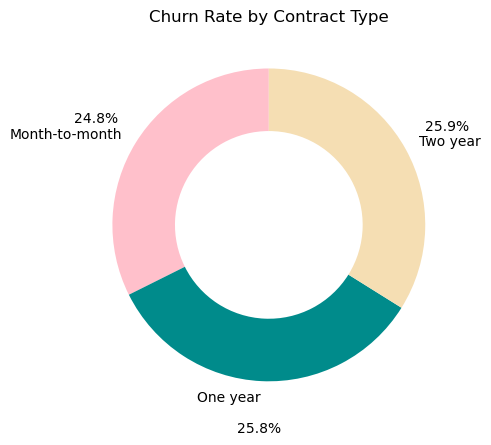

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for trigonometric functions

# Load the dataset
df = pd.read_csv('Telco_Churn_Customer.csv')

# Convert the 'CHURNED' column to a binary format: 1 for churned, 0 for not churned
df['Churned_Binary'] = df['CHURNED'].apply(lambda x: 1 if x == 'Yes' else 0)

# Filter dataset to include only churned customers
churned_df = df[df['Churned_Binary'] == 1]

# Group by customer type and calculate churn rates for churned customers only
churn_rate_by_type = churned_df.groupby('Contract')['Churned_Binary'].count() / df.groupby('Contract')['Churned_Binary'].count() * 100
churn_rate_by_type = churn_rate_by_type.reset_index()
churn_rate_by_type.columns = ['Contract', 'Churn_Rate (%)']

# Prepare data for the donut chart
data = churn_rate_by_type['Churn_Rate (%)']
labels = churn_rate_by_type['Contract']

# Specify colors manually
colors = ['pink', 'darkcyan', 'wheat']  # Add or adjust colors as needed

# Plotting
plt.figure(figsize=(5, 5))

# Create the donut chart without inside labels
wedges, texts = plt.pie(data, labels=labels, startangle=90,
                        colors=colors, wedgeprops=dict(width=0.4))

# Adding a title
plt.title('Churn Rate by Contract Type')

# Adding outside labels
for i, (wedge, label) in enumerate(zip(wedges, labels)):
    ang = (wedge.theta2 + wedge.theta1) / 2  # Calculate the angle
    x = (1.3 * wedge.r) * np.cos(np.deg2rad(ang))  # Position x
    y = (1.3 * wedge.r) * np.sin(np.deg2rad(ang))  # Position y
    plt.text(x, y, f'{data[i]:.1f}%', ha='center', va='center', fontsize=10)

# Save and show the plot
plt.tight_layout()
plt.savefig('churn_rate_donut_chart_churned_only_no_inside_labels.png', format='png', dpi=300)
plt.show()


CHURNED
No     14900
Yes     5100
Name: count, dtype: int64
   Age Group                      CHURN_REASON  Count
0      11-20      Attitude of service provider     10
1      11-20        Attitude of support person     18
2      11-20     Competitor had better devices      9
3      11-20      Competitor made better offer     15
4      11-20                          Deceased     14
..       ...                               ...    ...
93    71-100  Poor expertise of online support    100
94    71-100   Poor expertise of phone support    110
95    71-100                    Price too high     96
96    71-100           Product dissatisfaction     80
97    71-100           Service dissatisfaction     88

[98 rows x 3 columns]


C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_24068\2786465780.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churned['Age Group'] = pd.cut(df_churned['AGE'], bins=[0, 20, 30, 40, 50, 60, 70, 100],
C:\Users\Vaishanavi\AppData\Local\Temp\ipykernel_24068\2786465780.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_churn_count = df_churned.groupby(['Age Group', 'CHURN_REASON']).size().reset_index(name='Count')


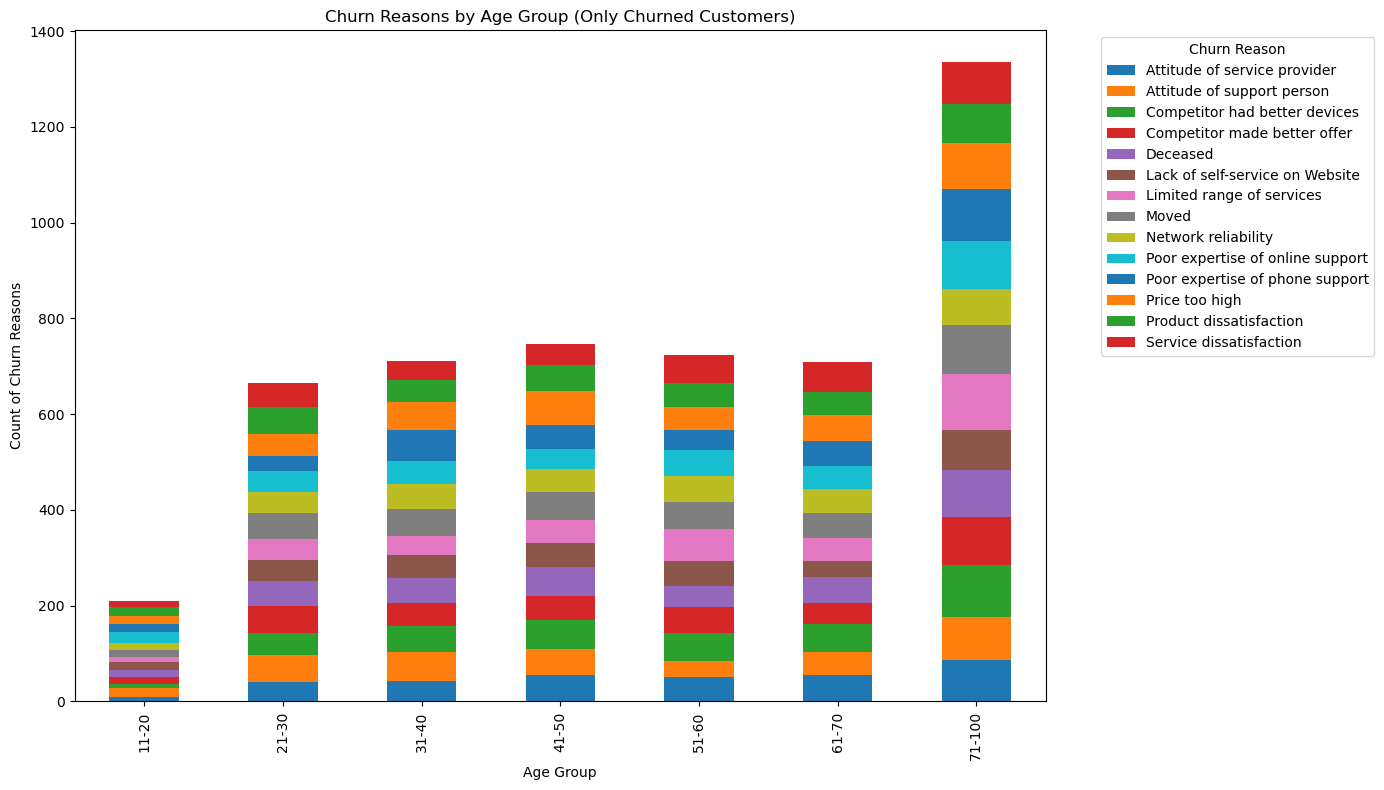

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Telco_Churn_Customer.csv')

# Check the unique values in the CHURN column to understand its contents
print(df['CHURNED'].value_counts())

# Filter the data to include only customers who have churned
df_churned = df[df['CHURNED'] == 'Yes']  # Adjust the condition if the column uses 'Yes' instead of 1

# Ensure the AGE column exists and create the 'Age Group' column
df_churned['Age Group'] = pd.cut(df_churned['AGE'], bins=[0, 20, 30, 40, 50, 60, 70, 100],
                                 labels=['11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-100'])

# Group the data by Age Group and Churn Reason, then count occurrences
age_group_churn_count = df_churned.groupby(['Age Group', 'CHURN_REASON']).size().reset_index(name='Count')

# Display the churn reasons count for each age group
print(age_group_churn_count)

# Check if the resulting DataFrame is empty
if age_group_churn_count.empty:
    print("No churned customers found or no matching churn reasons. Please check your dataset.")
else:
    # Create a pivot table to make plotting easier
    pivot_table = age_group_churn_count.pivot(index='Age Group', columns='CHURN_REASON', values='Count').fillna(0)

    # Plotting the data using a bar plot
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 8))

    plt.title('Churn Reasons by Age Group (Only Churned Customers)')
    plt.xlabel('Age Group')
    plt.ylabel('Count of Churn Reasons')
    plt.legend(title='Churn Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
